## Student: Tyler Lang

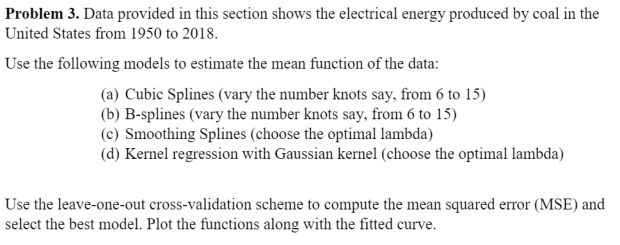

For this question, I will follow all parts, A-D, and use the type of spline specified, discussing my process of spline creation and tuning. Each spline requires tuning either with the number of knots, or with a smoothing parameter, lambda. To tune, Leave-One-Out-Cross-Validation will be used (LOOCV), initially with no test set to test against. I will be treating all 69 points to be considered as a single training set, and thus, when comparing models, I will just compare their LOOCV MSE, as the goal of this homework is ultimately to practice creating these splines, and not necessarily finding the best, most robust spline. In that case, we'd need more data to be able to separate out a test set to test the ultimate final models on to pick the absolute best model. But, as also indicated to be the best practice in Piazza, all 69 points will be used to perform validation per-model, and these MSEs per A-D will be compared.

NOTE: a lot of code is derived from the example code, and thus not lines of example code will be annotated.  All code not reflecting direct code from the sample code is my own code.

In [1]:
from scipy.ndimage import gaussian_filter
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.spatial import distance_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from scipy.interpolate import splrep, splev
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import interpolate
from matplotlib.patches import Rectangle

In [2]:
def BSplineBasis(x: np.array, knots: np.array, degree: int) -> np.array:
    nKnots = knots.shape[0]
    lo = min(x[0], knots[0])
    hi = max(x[-1], knots[-1])
    augmented_knots = np.append(
        np.append([lo]*degree, knots), [hi]*degree)
    DOF = nKnots + degree +1 # DOF = K+M, M = degree+1
    spline = BSpline(augmented_knots, np.eye(DOF),
                     degree, extrapolate=False)
    B = spline(x)
    return B

I first load the data and plot it, to understand what I will be looking at in the future sub-problems of this problem. Then, I define x and y variables to use in further data manipulation:

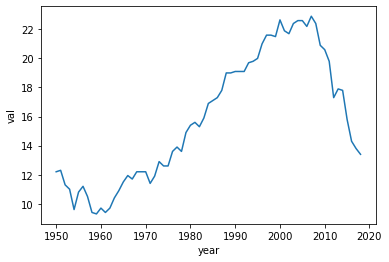

In [3]:
q3 = pd.read_csv(r'../P04.csv',header=None).rename({0:'year',1:'val'},axis=1)
sns.lineplot(data=q3,x='year',y='val')
plt.show()

In [4]:
x=q3['year']
y=q3['val']
xx=np.array(q3['year']-1950)
x_copy = x.copy()

# Part A - Cubic Splines

To create a cubic spline, I create my own function, which takes x values, which represent the linear space of our 2D real-space; y values, which are our functional measures, or independent datapoints, and finally the number of knots, which will be evenly spaced on the line. Power=3 is set to default, as we are dealing with cubic splines specifically. Even though I make this a changeable parameter, it is used at its default value of 3 for all pieces of this problem, thus adhering to being a cubic spline.

For the cubic spline, I have to construct our basis matrix, H. to start, I create the knot locations on the x-axis, And then set the rows of H as the following: 

- $H_1$ is set to 1, as with all spline bases. 
- Then, $H_2$ through $H_{power}$ are simply set to being each successive power of x, up to the max power (3, in this case).
- Finally, the final rows of H are set to be (x - knot) raised to the 3rd power, which form the bases of the spaces in between the knots.

In [5]:
def CubicSpliner(x,y,kn=5,power=3):
    knots = np.linspace(min(x),max(x),kn)
    knots = knots[1:kn-1]
    H = np.ones((len(knots)+power+1,len(x)))
    for p in range(1,power+1):
        H[p,:] *= x**(p)
    for k in range(1,len(knots)+1):
        H[k+power,:] = (x-knots[k-1])**power
        H[k+power,:] = np.where(H[k+power,:] >= 0,H[k+power,:],0)
    return H.T

For this problem, I will be tuning the number of knots, which I will range from 6 to 15. With a simple for-loop, I will plot all splines with these values of knots, to see the points in the graph in which the spline is most sensitive to the number of knots (the space where the differences in the plotted lines are most different):

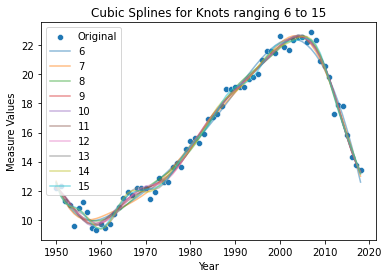

In [6]:
sns.scatterplot(x=x,y=y,label='Original')
for kn in range(6,16):
    H = CubicSpliner(xx,y,kn=kn)
    Bcubic = (np.linalg.inv(H.T@H)@H.T)@y
    sns.lineplot(x=x,y=H@Bcubic,label=kn,alpha=0.5)
plt.title('Cubic Splines for Knots ranging 6 to 15')
plt.xlabel('Year')
plt.ylabel('Measure Values')
plt.show()

As can be seen, we see at the hills and valleys of the curves are the points at which there is the most difference in spline creation based on the number of knots given, especially in the tight valleys. Now that we can visualize the differences in the splines with different numbers of knots, I will use LOOCV to tune the optimal number of knots.

To perform LOOCV, I create the H matrix, which is not dependent on any given point being left out. In other words, H doesn't change, or the algebra required to create H does not make any row of H dependent on the other. Thus, as shown in the sample code and in lecture, H is created independently, and then to perform LOOCV, for each point "i", the i'th row of H is taken out, and the i'th point of our y vector is also removed. Then, using linear algebra, a new B-matrix is created, which serves as our final spline basis. To predict the i'th point, we simply must matrix-multiply H[i] by the L-O-O B-matrix, and calculate the MSE. 

In [7]:
mse_cubic = []
for kn in range(6,16):
    H = CubicSpliner(xx,y,kn=kn)
    cv = []
    for i in range(len(q3)):
        Hnew = np.delete(H,i,axis=0)
        Bnew = np.linalg.inv(Hnew.T@Hnew)@Hnew.T@np.array(y.drop(i))
        cv.append((y[i]-H[i,:]@Bnew)**2)
    mse_cubic.append(pd.Series(cv).mean())

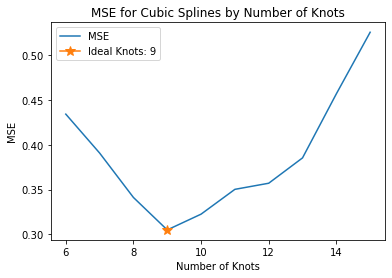

In [8]:
ideal_kn_ind = np.argwhere(mse_cubic==np.min(mse_cubic))[0][0]
ideal_kn = mse_cubic[ideal_kn_ind]
sns.lineplot(x=range(6,16),y=mse_cubic, label='MSE')
label = f'Ideal Knots: {range(6,16)[ideal_kn_ind]}'
plt.plot(range(6,16)[ideal_kn_ind], mse_cubic[ideal_kn_ind], marker="*", markersize=10,label = label)
plt.title('MSE for Cubic Splines by Number of Knots')
plt.xlabel('Number of Knots')
plt.ylabel('MSE')
plt.legend()
plt.show()

As can be seen, the ideal number of knots is 9! With 9 knots, the LOOCV MSE is minimized. Thus, to create a final spline, I will do so with 9 knots, and visualize it: 

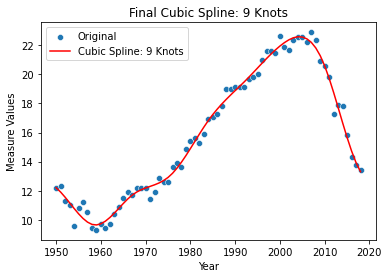

In [9]:
sns.scatterplot(x=x,y=y,label='Original')
H = CubicSpliner(xx,y,kn=range(6,16)[ideal_kn_ind])
Bcubic = (np.linalg.inv(H.T@H)@H.T)@y
sns.lineplot(x=x,y=H@Bcubic,label='Cubic Spline: 9 Knots',color='r')
plt.title('Final Cubic Spline: 9 Knots')
plt.xlabel('Year')
plt.ylabel('Measure Values')
plt.show()

Looks great! Finally, I print the LOOCV MSE below, for reference:

In [10]:
print(f'The Minimum MSE for Cubic Spline LOOCV = {round(pd.Series(mse_cubic).min(),3)}')

The Minimum MSE for Cubic Spline LOOCV = 0.305


# Part B: B-Splines

B-splines are splines with an altered basis, and thus I will now try the same process of creating B-splines with knots 6 through 15, tune the optimal knot amount, and finally plot the final B-spline.

The process is nearly the same as above, but I will use the function BSplineBasis, which is given in the sample code to create a B-spline basis in Python:

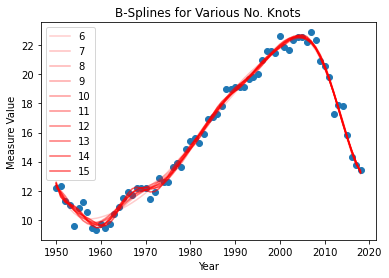

In [11]:
plt.scatter(x,y)
for kn,alpha in zip(range(6,16),np.arange(.2,.8,.05)):
    knots = np.linspace(min(xx),max(xx),kn)
    B = BSplineBasis(xx,knots,4)[:,:-2]
    sns.lineplot(x=x,y=B@np.linalg.inv(B.T@B)@B.T@y,color='r',alpha=alpha,label=kn)
plt.legend()
plt.title('B-Splines for Various No. Knots')
plt.xlabel('Year')
plt.ylabel('Measure Value')
plt.show()

Again, as can be seen, we can see the hills and valleys with the most variance in spline value across the different values of knots! 

Next, again, the number of knots will be tuned in the same way as in part A, using LOOCV.

In [12]:
mse_bs = []
for kn in range(6,16):
    knots = np.linspace(min(xx),max(xx),kn)
    B = BSplineBasis(xx,knots,4)[:,:-2]
    cv = []
    for i in range(len(q3)):
        Bnew = np.delete(B,i,axis=0)
        BS = np.linalg.inv(Bnew.T@Bnew)@Bnew.T@np.array(y.drop(i))
        #plt.imshow(Bnew.T@Bnew)
        #plt.show()
        cv.append((y[i]-B[i,:]@BS)**2)
    mse_bs.append(pd.Series(cv).mean())

In [13]:
xx.shape

(69,)

In [14]:
B.shape

(69, 18)

In [15]:
print(B.shape, Bnew.shape,xx.shape,BS.shape)

(69, 18) (68, 18) (69,) (18,)


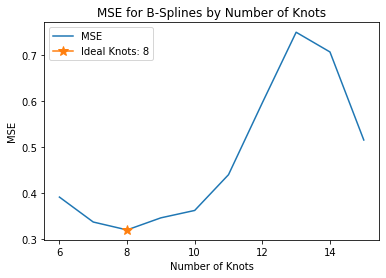

In [16]:
ideal_kn_ind_bs = np.argwhere(mse_bs==np.min(mse_bs))[0][0]
ideal_kn_bs = mse_bs[ideal_kn_ind_bs]
sns.lineplot(x=range(6,16),y=mse_bs, label='MSE')
label = f'Ideal Knots: {range(6,16)[ideal_kn_ind_bs]}'
plt.plot(range(6,16)[ideal_kn_ind_bs], mse_bs[ideal_kn_ind_bs], marker="*", markersize=10,label = label)
plt.title('MSE for B-Splines by Number of Knots')
plt.xlabel('Number of Knots')
plt.ylabel('MSE')
plt.legend()
plt.show()

As can be seen, now the optimal number of knots is 8, not 9 like with the cubic spline. 

Thus, again, I will create a final B-spline with 8 knots using all data points:

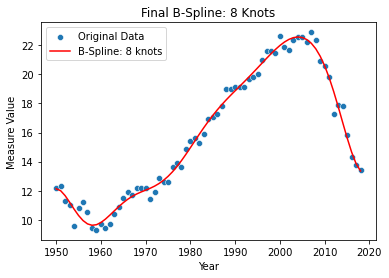

In [17]:
sns.scatterplot(x=x,y=y,label='Original Data')

knots = np.linspace(min(xx),max(xx),range(6,16)[ideal_kn_ind_bs])
B = BSplineBasis(xx,knots,4)[:,:-2]
sns.lineplot(x=x,y=B@np.linalg.inv(B.T@B)@B.T@y,color='r',label='B-Spline: 8 knots')
plt.title('Final B-Spline: 8 Knots')
plt.xlabel('Year')
plt.ylabel('Measure Value')
plt.legend()
plt.show()

This also looks great! Finally, I print the LOOCV MSE below, for reference:

In [18]:
print(f'The Minimum MSE for B-Spline LOOCV = {round(pd.Series(mse_bs).min(),3)}')

The Minimum MSE for B-Spline LOOCV = 0.319


As can be seen, this is a bit higher than the Cubic Spline, and certain sections show why this may be, such as the cluster of points near 1960: In the cubic spline, the curve was better fit to these points, whereas the B-spline in this interval is slightly dragged leftward.

# Part C - Smoothing Splines

Smoothing splines are a more complicated form of spline in which we have many more knots, which generally might overfit, but THEN, we add smoothing parameters controlled by a value denoted as Lambda to control smoothing, and thus avoid overfitting! 

This process will be outlined below. Note that 40 knots are used, due to advice on Piazza about values higher than 40 leading to unstable results. 

In this process, we will use B-splines as our basis, but a smoothing factor will be added to smooth out overfitting with 40 knots. 

To create this smoothing factor, we take the difference between the different values of the basis per row, creating B2. Then, we create a value called omega by using linear algebra as a smoother manipulation. Finally, 1001 potential values of lambda are defined, which I will loop over, to perform LOOCV. The LOOCV will follow nearly the exact same procedure as above, except that this time I am tuning for the optimal lambda. The smoothing factor shows up as an added factor in the final inverse, which is equal to lambda $^*$ omega. 

First, just for reference, I will show what the original B-spline would look like with 40 knots: 

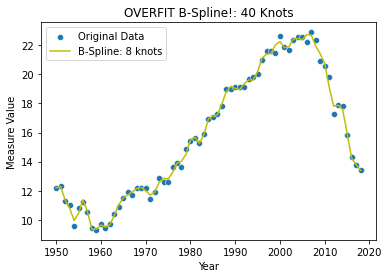

In [19]:
sns.scatterplot(x=x,y=y,label='Original Data')

knots = np.linspace(min(xx),max(xx),40)
B = BSplineBasis(xx,knots,4)[:,:-2]
sns.lineplot(x=x,y=B@np.linalg.inv(B.T@B)@B.T@y,color='y',label='B-Spline: 8 knots')
plt.title('OVERFIT B-Spline!: 40 Knots')
plt.xlabel('Year')
plt.ylabel('Measure Value')
plt.legend()
plt.show()

Notice how overfit this is! It's practically a slightly smoothed simple line chart of the original data. Thus, lets perform LOOCV to find the optimal smoothing factor, and plot the final value.

In the next cell, I define all the variables needed, including the basis, and omega.

In [33]:
k=40
n=len(xx)
D=np.linspace(0,1,n)

knots = np.linspace(0, 1, k)
B = BSplineBasis(D,knots,4)[:,:-2]

B2 = np.diff(B, axis=0, n=2)*(n-1)**2 
omega = B2.T.dot(B2)/(n-2)

In [34]:
B.shape

(69, 43)

In [35]:
B2.shape

(67, 43)

In the next graph, just as a visual, we can see how the smoothing spline changes based on different values of lambda! This is just a visual tool to show how the variation of lambda effects the final result:

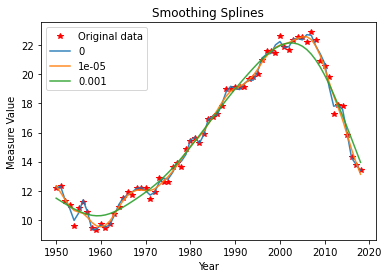

In [21]:
test_lams = [0,.00001,.001]
plt.plot(x, y, 'r*', label='Original data')
for lam in test_lams:
    S = B@np.linalg.inv(B.T@B+lam*omega)@B.T  
    yhat = S@y
    plt.plot(x, yhat, alpha=0.9,label=lam)
plt.title("Smoothing Splines")
plt.xlabel('Year')
plt.ylabel('Measure Value')
plt.legend()
plt.show()

Notice how, when lambda = 0, we see the same extremely overfit curve. Then, looking at different values of lambda, we see how one potential value of lambda (1e-05) has a potentially reasonable fit, and finally a much larger value of lambda (.001) leads to an obvious under-fit.

Thus, now knowing how lambda values affect our final spline, I will tune the best lambda:

In [36]:
lams = np.arange(0, 1e-4, 1e-6)
MSE_c = []
df = []

for lam in lams:
    cv = []
    for row in range(len(y)):
        Bnew = np.delete(B,row,axis=0)
        BS = np.linalg.inv(Bnew.T@Bnew+lam*omega)@Bnew.T@np.array(pd.Series(y).drop(row))
        S = np.linalg.inv(Bnew.T@Bnew+lam*omega)@Bnew.T
        cv.append((y[row]-B[row,:]@BS)**2)
    MSE_c.append(np.mean(cv))    
    df.append(np.trace(S))
MSE_c = np.array(MSE_c)
df = np.array(df)

In [38]:
print(Bnew.shape, B.shape, BS.shape, np.array(pd.Series(y).drop(row)).shape, (np.linalg.inv(Bnew.T@Bnew+lam*omega)@Bnew.T).shape)

(68, 43) (69, 43) (43,) (68,) (43, 68)


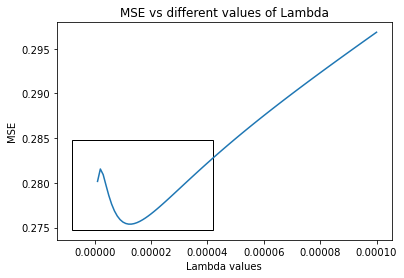

In [23]:
someX, someY = lams[2], MSE_c[4] 
plt.figure()
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((someX - .00001, someY - .005), .00005,.01, fill=None, alpha=1))
sns.lineplot(x=lams[1:],y=MSE_c[1:])
plt.title('MSE vs different values of Lambda')
plt.xlabel('Lambda values')
plt.ylabel('MSE')
plt.show()

As can be seen, there is a small range of lambdas in which the MSE is not explicitly increasing due to increased smoothing, which is shown in the rectangle area. In the next cell, I will zoom in on this area to visualize the minimized MSE and the optimal lambda value:

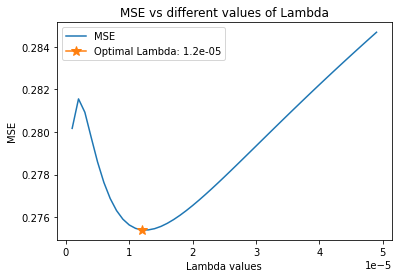

In [24]:
ideal_lam_index = np.argwhere(np.array(MSE_c) == MSE_c.min())[0][0]
ideal_lam = lams[ideal_lam_index]
sns.lineplot(x=lams[1:50],y=MSE_c[1:50],label='MSE')
label = f'Optimal Lambda: {ideal_lam}'
plt.plot(lams[ideal_lam_index], MSE_c[ideal_lam_index], marker="*", markersize=10,label = label)
plt.title('MSE vs different values of Lambda')
plt.xlabel('Lambda values')
plt.ylabel('MSE')
plt.legend()
plt.show()

As can be seen, the optimal, minimized MSE occurs at lambda = 1.2e-05! 

Thus, again, I will create a final smoothed spline to visualize, and report on the validation MSE:

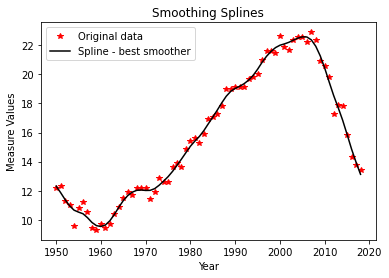

In [25]:
S = B@np.linalg.inv(B.T@B+ideal_lam*omega)@B.T
yhat = S@y
plt.plot(x, y, 'r*', label='Original data')
plt.plot(x, yhat, 'k-', label='Spline - best smoother')
plt.legend()
plt.title("Smoothing Splines")
plt.xlabel('Year')
plt.ylabel('Measure Values')
plt.show()

In [26]:
print(f'The Minimum MSE for Smoothing Splines LOOCV = {round(pd.Series(MSE_c).min(),3)}')

The Minimum MSE for Smoothing Splines LOOCV = 0.275


Note: Of parts a-c, this is the lowest validation MSE so far! 

# Part D - Gaussian Kernel

Finally, for part D, I will use a gaussian kernel to manipulate the data into a smooth curve. 

To do so, different bandwidths, or values of what is also denoted as lambda, are used to alter the input data, which is then fed into a kernel function - in this case, a guassian kernel, which is a defined function.

This process is a bit different from those above, due to the kernel, but we are still using LOOCV to get the MSE scores. The MSE per bandwidth, or lambda, is plotted, and then this final optimal value is passed on to the final iteration of the kernel transformation, in which the final curve is plotted: 

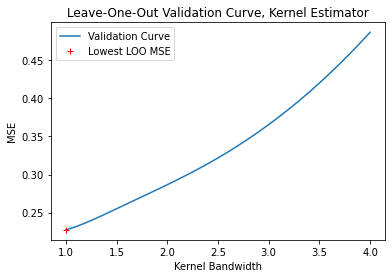

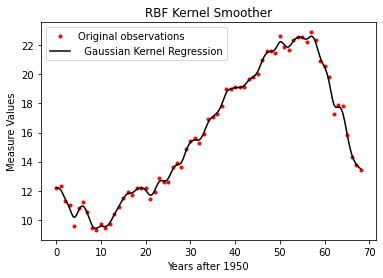

In [27]:
x = xx.copy()
y = np.array(y)

def kerf(z):
    return np.e**(-z**2)/(np.sqrt(2*np.pi))

bandwidths = np.arange(1, 4.001, 0.1)
MSEs = []
for w in bandwidths:
    loo = LeaveOneOut()
    errs = []
    for trg, tst in loo.split(x):
        z = kerf((x[tst]-x[trg])/w)
        yke = np.average(y[trg], weights=z)
        errs.append(y[tst]-yke)
    MSEs.append(np.mean([err**2 for err in errs]))
MSEs = np.array(MSEs).squeeze()
w_star = bandwidths[np.argmin(MSEs)]
plt.plot(bandwidths, MSEs, label='Validation Curve')
plt.plot(w_star, min(MSEs),'r+', label='Lowest LOO MSE')
plt.title('Leave-One-Out Validation Curve, Kernel Estimator')
plt.xlabel('Kernel Bandwidth')
plt.ylabel('MSE')
plt.legend()
plt.show()

w_star = bandwidths[np.argmin(MSEs)]

N = 1000
qq = np.linspace(min(x), max(x), N)
yy = []
for qq_ in qq:
    z = kerf((qq_-x)/w_star)
    yy.append(np.average(y, weights=z))
plt.plot(x, y, 'r.', label='Original observations')
plt.plot(qq, yy, 'k', label='  Gaussian Kernel Regression')
plt.xlabel('Years after 1950')
plt.ylabel('Measure Values')
plt.legend()
plt.title('RBF Kernel Smoother')
plt.show()

In [28]:
print(f'The Minimum MSE for Gaussian Kernel LOOCV = {round(pd.Series(MSEs).min(),3)}')

The Minimum MSE for Gaussian Kernel LOOCV = 0.227


As can be seen, the final curve is much more bumpy, and possibly overfitting, even if based on a bandwidth found to be the optimum using LOOCV. Whether or not it is actually overfitting is hard to know without comparing to test data, but the validation MSE is quite nice and low: 0.227, which is the lowest thus far. 

# Appendix: Comparison of models

As a final summary of this question, I will compare all 4 curves, and their differences:

First, I will plot all 4 again so we can see the visual differences among them: 

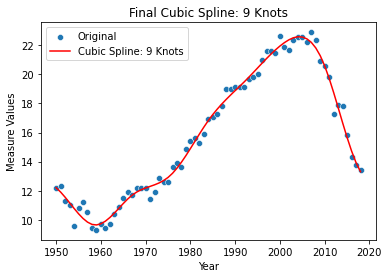

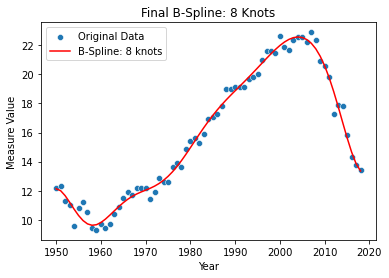

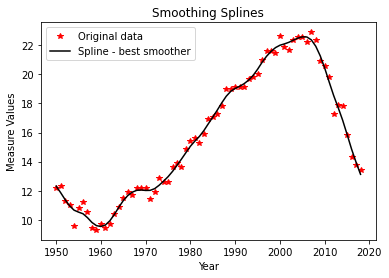

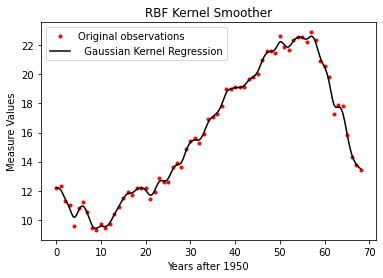

In [29]:
x=q3['year']
y=q3['val']
xx=np.array(q3['year']-1950)

sns.scatterplot(x=x,y=y,label='Original')
H = CubicSpliner(xx,y,kn=range(6,16)[ideal_kn_ind])
Bcubic = (np.linalg.inv(H.T@H)@H.T)@y
sns.lineplot(x=x,y=H@Bcubic,label='Cubic Spline: 9 Knots',color='r')
plt.title('Final Cubic Spline: 9 Knots')
plt.xlabel('Year')
plt.ylabel('Measure Values')
plt.show()


sns.scatterplot(x=x,y=y,label='Original Data')
knots = np.linspace(min(xx),max(xx),range(6,16)[ideal_kn_ind_bs])
B = BSplineBasis(xx,knots,4)[:,:-2]
sns.lineplot(x=x,y=B@np.linalg.inv(B.T@B)@B.T@y,color='r',label='B-Spline: 8 knots')
plt.title('Final B-Spline: 8 Knots')
plt.xlabel('Year')
plt.ylabel('Measure Value')
plt.legend()
plt.show()

k=40
n=len(xx)
D=np.linspace(0,1,n)
knots = np.linspace(0, 1, k)
B = BSplineBasis(D,knots,4)[:,:-2]
S = B@np.linalg.inv(B.T@B+ideal_lam*omega)@B.T
yhat = S@y
plt.plot(x, y, 'r*', label='Original data')
plt.plot(x, yhat, 'k-', label='Spline - best smoother')
plt.legend()
plt.title("Smoothing Splines")
plt.xlabel('Year')
plt.ylabel('Measure Values')
plt.show()


x = xx.copy()
y = np.array(y)
w_star = bandwidths[np.argmin(MSEs)]
N = 1000
qq = np.linspace(min(x), max(x), N)
yy = []
for qq_ in qq:
    z = kerf((qq_-x)/w_star)
    yy.append(np.average(y, weights=z))
plt.plot(x, y, 'r.', label='Original observations')
plt.plot(qq, yy, 'k', label='  Gaussian Kernel Regression')
plt.xlabel('Years after 1950')
plt.ylabel('Measure Values')
plt.legend()
plt.title('RBF Kernel Smoother')
plt.show()

As a summary, here are the MSEs of LOOCV for each as well: 

In [30]:
print(f'The Minimum MSE for Cubic Spline LOOCV = {round(pd.Series(mse_cubic).min(),3)}')
print(f'The Minimum MSE for B-Spline LOOCV = {round(pd.Series(mse_bs).min(),3)}')
print(f'The Minimum MSE for Smoothing Splines LOOCV = {round(pd.Series(MSE_c).min(),3)}')
print(f'The Minimum MSE for Gaussian Kernel LOOCV = {round(pd.Series(MSEs).min(),3)}')

The Minimum MSE for Cubic Spline LOOCV = 0.305
The Minimum MSE for B-Spline LOOCV = 0.319
The Minimum MSE for Smoothing Splines LOOCV = 0.275
The Minimum MSE for Gaussian Kernel LOOCV = 0.227


From these numbers alone, it would appear that the **gaussian kernel is the best curve**, just from the cross-validation MSEs. Obviously, to truly know which curve is best and most robust, we'd need unseen datapoints to test each on. But as indicated, all 69 points were used in training and validation, and thus I can only report "best" based on which has the lowest validation MSE. 

Some other notes as well: We can definitely see a difference in the curves. The B-spline, for example, looks the smoothest and most generalized, perhaps missing a few of the sharp patterns in the original data, and specifically the bottom valley around 1960 being a bit pulled to the left by a seeming outlier down below, or also by the three point cluster in the top-left of this valley. Also, for B-splines and cubic splines, we can see slight peculiarities in the very first extreme point around 1950 and 1951, in which the curve flattens out toward the point at 1950, instead of going through the middle of the points for 1950 and 1951. 

With smoothing splines, this seems to pick up more of the subtle curves in the original data, making it much more wavy, but much more in tune with the seeming mean of the underlying trend, and more accurately curving in unison with the clusters of points. 

Finally, the tuned Gaussian Kernel is the most noisy of all, matching a lot of micro-trends, which could possibly lead to overfitting, even if leading to the best MSE at the given tuned bandwidth. It seems to best curve the extreme edges of the curve, while points like 1954 and the subsequent dip in the curve showing that, at least with the given bandwidth, its more susceptible to outlier influence.